# Задача 6. Компьютерное зрение: задача сегментации

**Автор**: Сергей Локтев

In [525]:
#!g1.1
%pip install opencv-python 
%pip install torchmetrics -U

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 61.8 MB 95 kB/s             
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 519 kB 3.1 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [526]:
#!g1.1
import copy
import random
from pathlib import Path
import numpy as np 
import cv2
import pandas as pd
import torch
import torch.utils.data
import torchmetrics
from matplotlib import pyplot as plt
from torch import nn
from torchvision import io
from torchvision import transforms
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange

In [527]:
#!g1.1
torchmetrics.__version__

'0.11.4'

In [528]:
#!g1.1
def reset_random_seeds():
    torch.manual_seed(42)
    random.seed(42)

## U-Net

In [529]:
#!g1.1
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2) 
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

# Data preparation

In [530]:
#!g1.1
import torchvision.transforms as tr
image_prepare = tr.Compose([
    tr.ToPILImage(),
    #tr.Resize((224, 224)),
    tr.ToTensor(),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=image_prepare):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img = self.transform(io.read_image(str(self.images[item])) / 255)
        mask = self.transform(io.read_image(str(self.masks[item])) / 255)
        return img, mask

In [531]:
#!g1.1
reset_random_seeds()

torch.Size([3, 800, 600])
torch.Size([1, 800, 600])


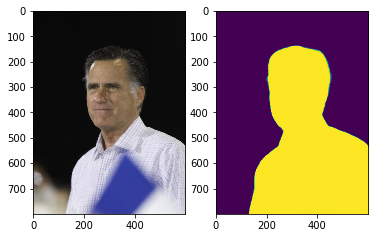

In [532]:
#!g1.1
np.random.seed(42)
def show_images(image, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(functional.to_pil_image(image))
    ax[1].imshow(functional.to_pil_image(mask))
image_paths = np.array(sorted(Path("dataset/images").iterdir()))
mask_paths = np.array(sorted(Path("dataset/masks").iterdir()))
random_mask = np.random.choice(len(image_paths), size=len(image_paths), replace=True)
image_paths, mask_paths = image_paths[random_mask], mask_paths[random_mask]
train_size = 0.85
train_dataset = Dataset(
    images=image_paths[:int(len(image_paths) * train_size)],
    masks=mask_paths[:int(len(mask_paths) * train_size)],
)
test_dataset = Dataset(
    images=image_paths[int(len(image_paths) * train_size):],
    masks=mask_paths[int(len(mask_paths) * train_size):],
)

image, mask = train_dataset[60]
print(image.shape)
print(mask.shape)
show_images(image, mask)

## Learning loop

In [533]:
#!g1.1
from collections import defaultdict
import torchmetrics
device = "cuda:0"
criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.classification.BinaryJaccardIndex().to(device)


def jaccard_index(pred, y):
    return jaccard(pred, y > jaccard.threshold)
def train(model, opt, loader, criterion, metric):
    model.train()
    losses_tr = []
    metric_tr = []
    for img_batch, mask_batch in tqdm(loader):
        img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
        pred = model(img_batch)
        loss = criterion(pred, mask_batch)
        metr = metric(pred, mask_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses_tr.append(loss.item())
        metric_tr.append(metr.item())
    
    return model, opt, np.mean(losses_tr), np.mean(metric_tr)


def val(model, loader, criterion, metric):
    model.eval()
    losses_val = []
    metric_val = []

    with torch.no_grad():
        for img_batch, mask_batch in tqdm(loader):
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            pred = model(img_batch)
            loss = criterion(pred, mask_batch)
            metr = metric(pred, mask_batch)

            losses_val.append(loss.item())
            metric_val.append(metr.item())
    
    return np.mean(losses_val), np.mean(metric_val)

from IPython.display import clear_output
import warnings


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    epochs=10,
    val_every=1,
    draw_every=1,
    metric=jaccard_index
):
    
    losses = {'train': [], 'val': []}
    metrics = {'train': [], 'val': []}
    lrs = []

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        
        model, optimizer, loss, metric_ = train(model, optimizer, train_loader, criterion, metric)
        losses['train'].append(loss)
        metrics['train'].append(metric_)
        
        if not (epoch % val_every):
            loss, metric_ = val(model, val_loader, criterion, metric)
            losses['val'].append(loss)
            metrics['val'].append(metric_)

        if not (epoch % draw_every):
            clear_output(True)
            print(metrics['train'])
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, 3, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            plt.grid()
            plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            plt.subplot(1, 3, 3)
            plt.title(f'jaccard')
            plt.plot(metrics['train'], 'r.-', label='train')
            plt.grid() 
            plt.plot(metrics['val'], 'g.-', label='val')
            plt.legend()          
            plt.show()
    return model, optimizer, losses

## Переобучение на батче

In [157]:
#!g1.1
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

[0.15971073508262634, 0.3062148690223694, 0.4398050904273987, 0.5418518781661987, 0.6098862290382385, 0.6683900356292725, 0.6979241371154785, 0.7120755314826965, 0.7314192652702332, 0.7519570589065552, 0.7841760516166687, 0.7656201124191284, 0.8048730492591858, 0.8549422025680542, 0.8637821674346924, 0.8584957718849182, 0.8804972767829895, 0.8996201157569885, 0.9239428043365479, 0.9455032348632812, 0.949121356010437, 0.9595264196395874, 0.9670624732971191, 0.9652565121650696, 0.946908175945282, 0.9724948406219482, 0.9670637249946594, 0.9732848405838013, 0.9669626951217651, 0.9718338251113892, 0.9644681811332703, 0.9789696335792542, 0.9729281067848206, 0.9817993640899658, 0.9815731048583984, 0.9834282398223877, 0.9862867593765259, 0.9836739301681519, 0.9844185709953308, 0.986289918422699, 0.9887502193450928, 0.9874761700630188, 0.9885737299919128, 0.989138662815094, 0.9896518588066101, 0.9896149635314941, 0.9906499981880188, 0.9910086393356323, 0.9910026788711548, 0.9915499091148376]


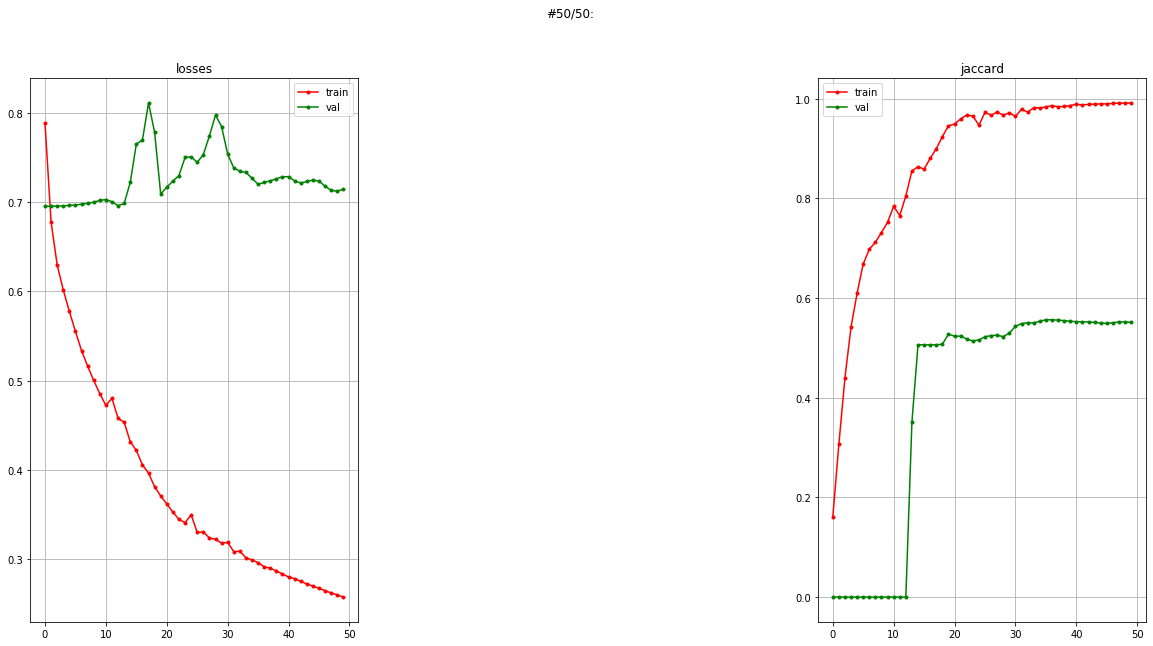

In [158]:
#!g1.1
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=50
)

### Видно, что на трейне жакар индекс почти 1, а на трейне все плохо, видимо переобучились

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


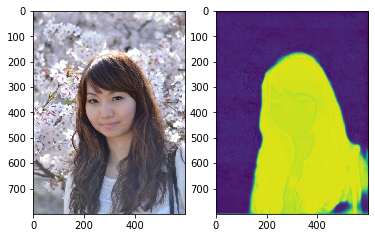

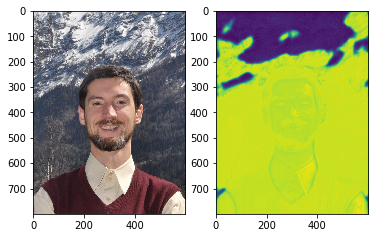

In [159]:
#!g1.1
model.eval()

X, y = train_dataset[0]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

X, _ = test_dataset[0]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

## Так и есть 

# Полное обучение

In [534]:
#!g1.1
batch_size = 32  

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

[0.5682535436418321, 0.7031844379725279, 0.7348463855407856, 0.7673773986321909, 0.7839952883897005, 0.8003229565090604, 0.8145209815767076, 0.8300673564275106, 0.8415124824753514, 0.8516921776312368, 0.8601668013466729, 0.868368500912631]
#13/40:



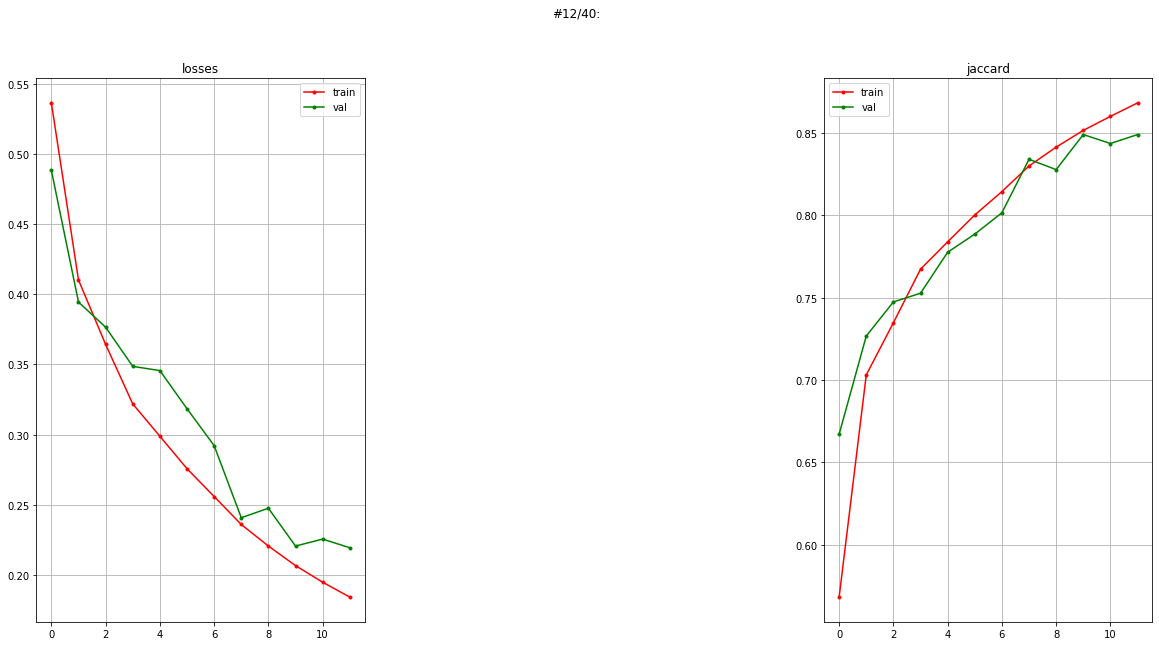

KeyboardInterrupt: 

In [161]:
#!g1.1
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=40
)

## Видно, что на тесте уже график начинает скакать, останавливаемся 

## Далее посмотрим на 3 худших (по jaccard index) результата, среди получаемых моделью на тестовых данных.

In [34]:
#!g1.1
def show_worst_test_cases(model, n):
    test_metrics = []
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataset):
            pred = model(X.to(device).unsqueeze(0))[0]
            test_metrics.append((jaccard_index(pred, y.to(device)).item(), i))

    idx = [i for _, i in sorted(test_metrics)[:n]]

    with torch.no_grad():
        for i in idx:
            X, _ = test_dataset[i]
            pred = model(X.to(device).unsqueeze(0))[0]
            show_images(X, nn.functional.sigmoid(pred))

    return idx

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


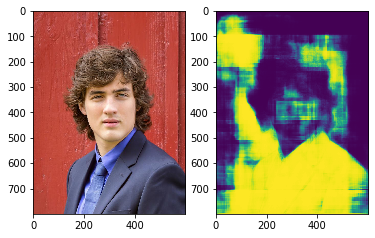

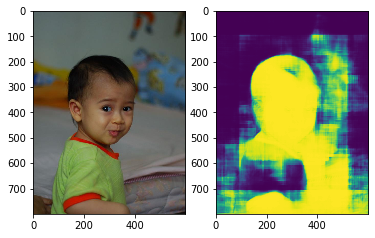

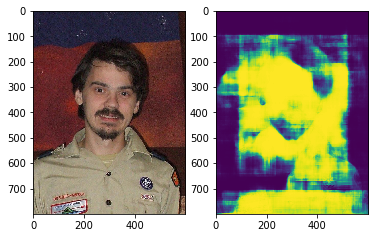

In [170]:
#!g1.1
worst_idxs = show_worst_test_cases(model, 3)

## Какие-то образы выделяет моделька, но слабенько

# Аугментации тренировочных данных

## Добавим аугментацию для улучшения скора

In [177]:
#!g1.1
image_prepare = tr.Compose([
    tr.ToPILImage(),
    tr.RandomHorizontalFlip(1),
    tr.ToTensor(),
])

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = image_prepare

image, _ = train_dataset[0]
augmented_image, _ = train_dataset_augmented[0]

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset, copy.copy(train_dataset)]
)
train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

[0.6511391905423637, 0.7328138150901438, 0.7789507970631679, 0.8193940069073828, 0.8462934861673372, 0.8593884216290768, 0.8780713571566288, 0.8894975580901743, 0.9008495462274997]
#10/15:



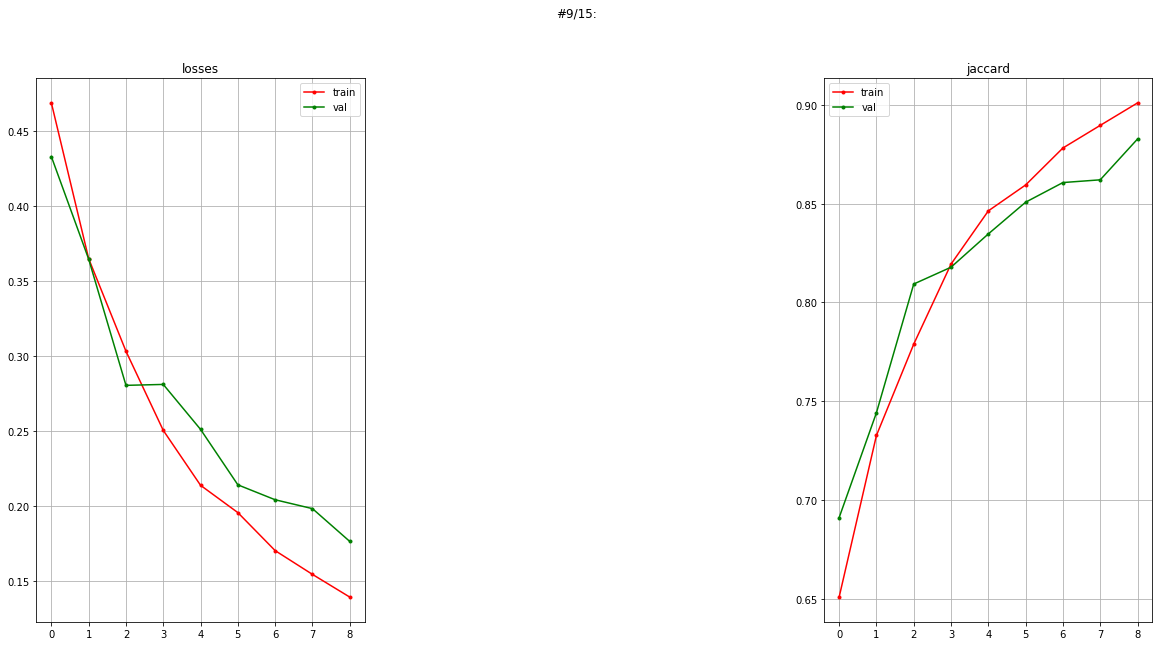

KeyboardInterrupt: 

In [178]:
#!g1.1
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())
model, _, _ = learning_loop(
    model, optimizer, train_loader_extended, test_loader, criterion, 
    epochs=15
)

## Видно, что моделька лучше учится и скор выше

# Test-time

In [184]:
#!g1.1
class UNetHFlipWrapper(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 16, n_levels: int = 1):
        super().__init__()
        self.unet = UNET(in_channels, out_channels, n_levels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)
        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)
        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)
        return means

In [185]:
#!g1.1
wrapped_model = UNetHFlipWrapper().to(device)
wrapped_model.unet.load_state_dict(model.state_dict());

In [190]:
#!g1.1
print("Flip-wrapped test results (loss, jaccard):", val(wrapped_model, test_loader, criterion, jaccard_index))
print("Default model test results (loss, jaccard):", val(model, test_loader, criterion, jaccard_index))


Flip-wrapped test results (loss, jaccard): (0.18372838348150253, 0.8789830923080444)

Default model test results (loss, jaccard): (0.16621542498469352, 0.881956672668457)


## Улучшения что-то незаметны

# VGG в энкодере

In [535]:
#!g1.1
from torchvision import models
vgg = models.vgg11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg11-8a719046.pth


In [536]:
#!g1.1
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [537]:
#!g1.1
features = vgg.features
blocks = []
i = 0
prev_i = 0
while i < len(features):
    i += 1 
    if i == len(features) or isinstance(features[i], nn.Conv2d):
        blocks.append(features[prev_i:i])
        prev_i = i
for block in blocks: 
    print(block)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
)
Sequential(
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
)
Sequential(
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [551]:
#!g1.1
class CNNBlocks(nn.Module):
    def __init__(self, block):
        super(CNNBlocks, self).__init__()
        self.layers = block

    def forward(self, x):
        x = self.layers(x)
        return x
    
class CNNBLOCKS(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBLOCKS, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, blocks):
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList()
        for block in blocks:
            self.enc_layers += [CNNBlocks(block)]

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks) and layer.layers[0].in_channels != layer.layers[0].out_channels:
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, blocks, exit_channels):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()
        self.layers += [nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2), nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)]
        i = 0
        for block in blocks[::-1]:
            out_channels, in_channels = block[0].in_channels, block[0].out_channels
            if out_channels != in_channels:
                self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                                CNNBLOCKS(n_conv=2, in_channels=in_channels+out_channels, out_channels=out_channels, padding=1)]
        self.layers.append(nn.Conv2d(out_channels, self.exit_channels, kernel_size=1, padding=0))
        self.layers.append(nn.ConvTranspose2d(self.exit_channels, self.exit_channels, kernel_size=3, padding=1, stride=2, output_padding=1))

    def forward(self, x, connections):
        cnt = 0 
        for layer in self.layers:
            if isinstance(layer, CNNBLOCKS):
                cnt += 1 
        for layer in self.layers:
            if isinstance(layer, CNNBLOCKS):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2) 
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, exit_channels):
        super(UNET, self).__init__()
        self.encoder = Encoder(blocks)
        self.decoder = Decoder(blocks, exit_channels)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [552]:
#!g1.1
import nvidia_smi
import gc

Миллион раз модельку пришлось удалять, так как она занимает почти 32 гига

In [553]:
#!g1.1
try:
    del optimizer
    del model
except:
    print(f'моделька уже удалена')
torch.cuda.empty_cache()
gc.collect()
nvidia_smi.nvmlInit()
deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

nvidia_smi.nvmlShutdown()

Device 0: b'Tesla V100-PCIE-32GB', Memory : (94.39% free): 34089730048(total), 32178176000 (free), 1911554048 (used)


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:912: UserWarning: The following variables cannot be serialized: handle
  warnings.warn(message)


[0.5149549350694373, 0.6734618577692244, 0.7892117047751391, 0.8116204407480028, 0.8307368015801465, 0.8460685776339637, 0.8562654300972268, 0.8693515647340704, 0.8788460040533984, 0.891595356994205, 0.9004150595929887, 0.9080254203743405, 0.9164779870598404, 0.9216461545891232, 0.9262480327376613]


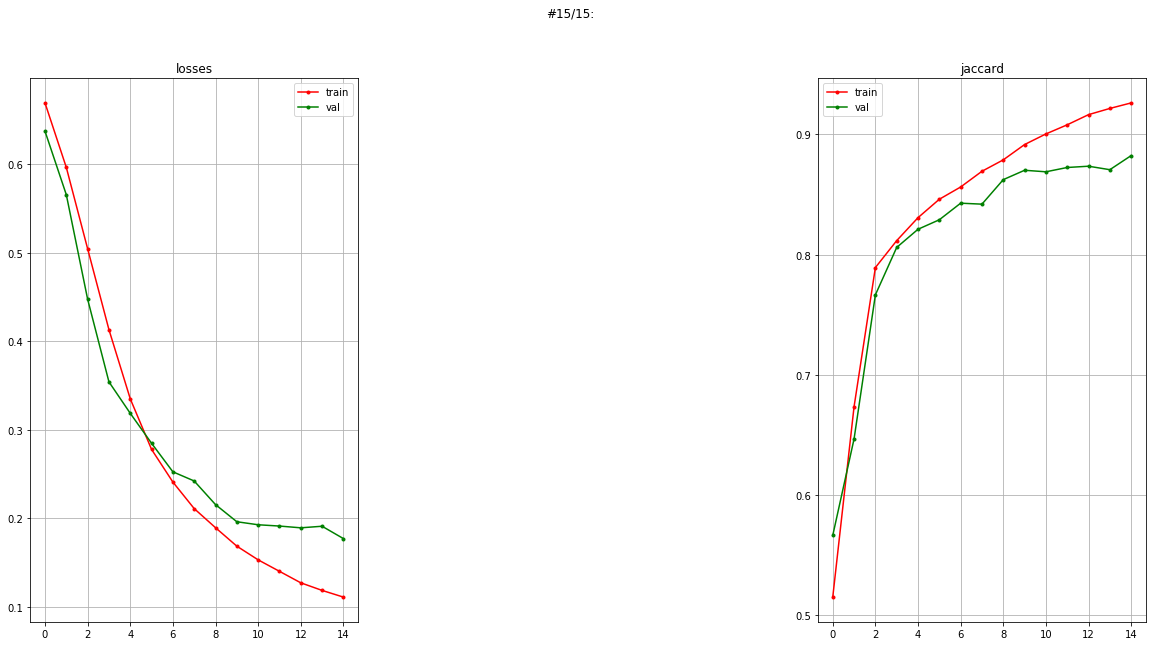

In [554]:
#!g1.1
model = UNET(1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=15
)

## Чистый vgg в энкодере показывает супер результаты, почти 0.9 жакард индекс

# Теперь VGG как экстрактор фичей для дефолтного UNET 

## VGG с замороженными весами

In [449]:
#!g1.1
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()
          
          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.extractor = vgg.features[:5]
        for param in self.extractor.parameters():
            param.requires_grad = False
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        x = self.extractor(x)
        convt = nn.ConvTranspose2d(128, 16, kernel_size=2, stride=2).to(device)
        x = convt(x.to(device))
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2) 
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

[0.5964396308969568, 0.6826399586818837, 0.7303462624549866, 0.7554820676644644, 0.7807340235621841, 0.7934821546077728, 0.8026847883507058, 0.8156202722478796, 0.8237638782571863, 0.8326641299106456, 0.8391988619610116, 0.844570482218707, 0.8488117081147654, 0.8512303398715125, 0.8574101406115072]


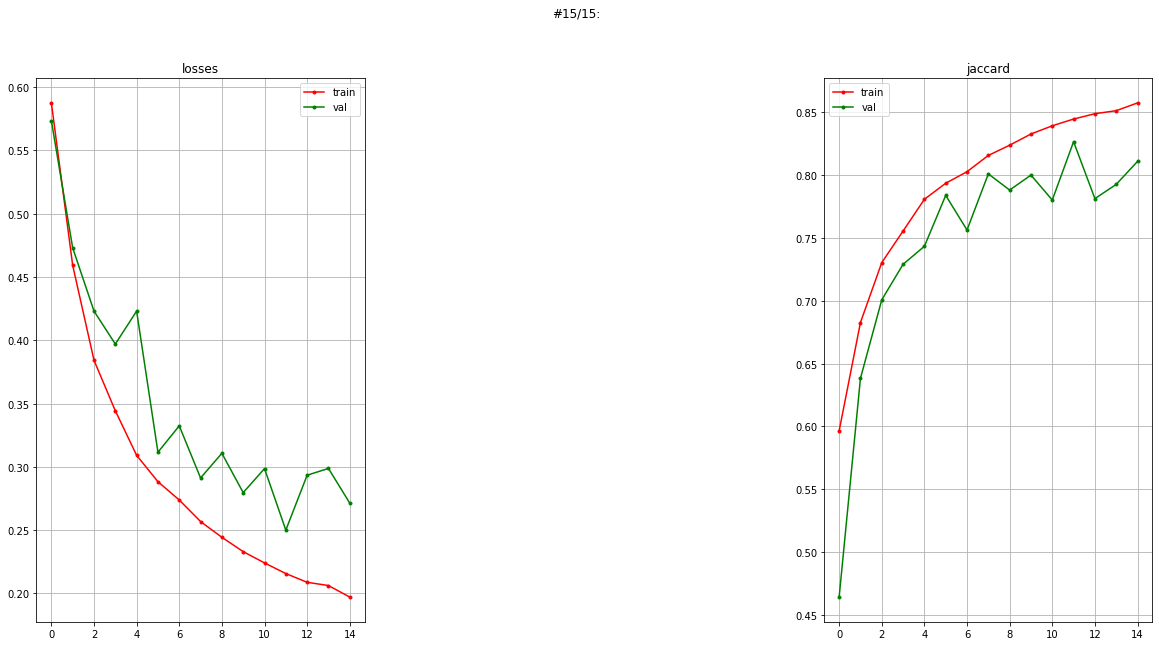

In [454]:
#!g1.1
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
model = UNET(16, 16, 1, 4).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=15
)

## Как-то слабенько, а если с размороженными весами

## VGG с размороженными весами

[0.5899793124861188, 0.6931212654820195, 0.7224403233439834, 0.752505017651452, 0.7778556170286955, 0.7904945468461072, 0.8005338863090232, 0.8112082944975959, 0.8217727023142355, 0.8279556941103052, 0.8321907575483676, 0.8452392871733065, 0.8503205102902872, 0.8570737949124089, 0.857832634890521]


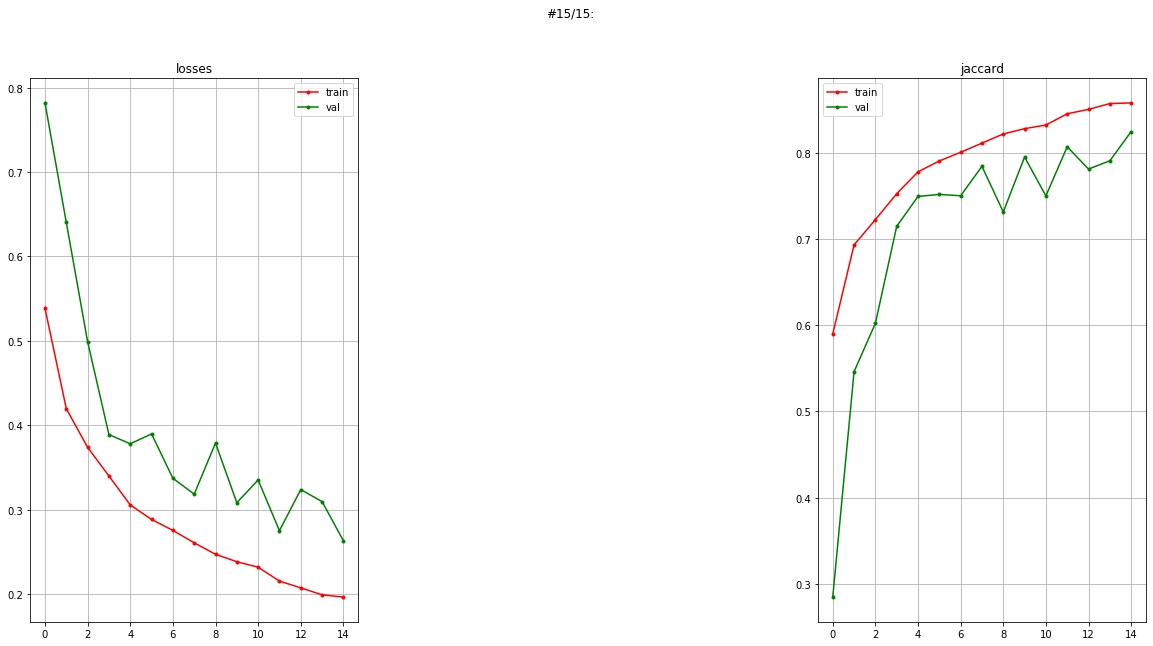

In [455]:
#!g1.1
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.extractor = vgg.features[:5]
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        x = self.extractor(x)
        convt = nn.ConvTranspose2d(128, 16, kernel_size=2, stride=2).to(device)
        x = convt(x.to(device))
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
model = UNET(16, 16, 1, 4).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=15
)

## Тоже слабенько как-то

# Cross-validation

In [22]:
#!g1.1
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
kfold = KFold(n_splits=5)
train_folds, val_folds = [], []
tr_data = train_dataset
for fold,(train_idx,test_idx) in enumerate(kfold.split(tr_data)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(
                      tr_data, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      tr_data,
                      batch_size=batch_size, sampler=test_subsampler)
    train_folds.append(trainloader)
    val_folds.append(testloader)
    
def run_kth_model(k, train_folds=train_folds, val_folds=val_folds, opts=opts):
    t = train_folds[k]
    tt = val_folds[k]
    mod = UNET(3, 16, 1).to(device)
    opt = torch.optim.Adam(mod.parameters())
    final, _, _ = learning_loop(mod, opt, t, tt, criterion)
    return final

In [23]:
#!g1.1
import gc
torch.cuda.empty_cache()
gc.collect()

86

[0.5821013180322425, 0.6586831253628398, 0.6973679162735162, 0.7277844478917677, 0.7438232746235159, 0.7629022598266602, 0.7804874597593795, 0.79350841461226, 0.8040592143701952, 0.8196411202120226]


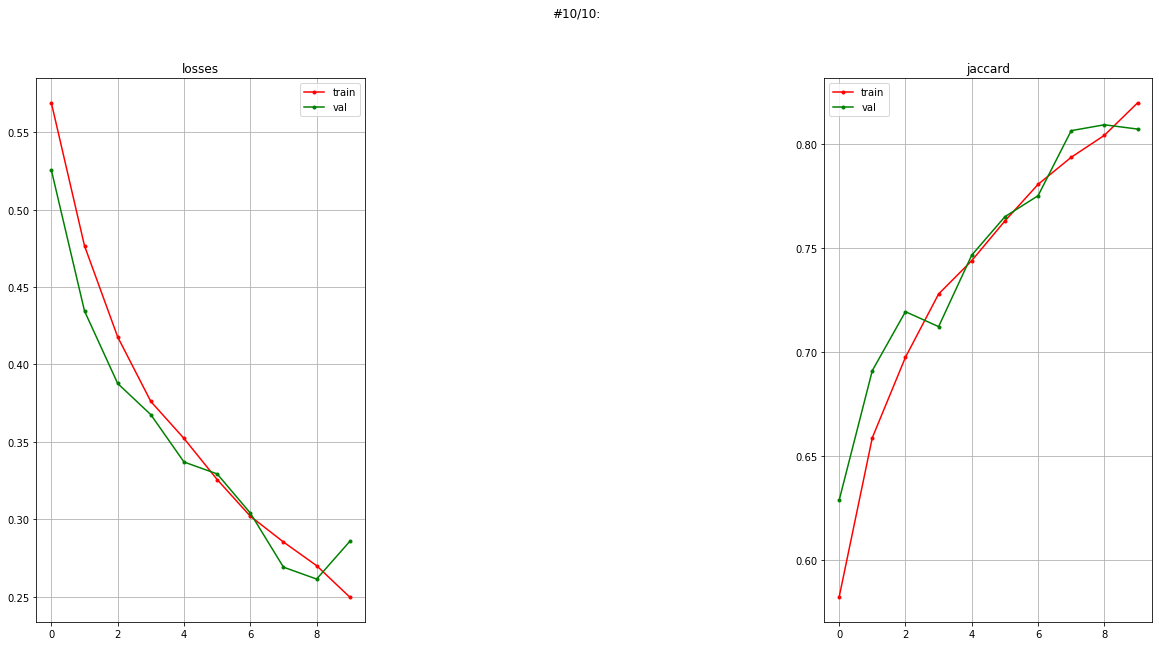

In [28]:
#!g1.4
first_model = run_kth_model(0)

[0.5060372276361599, 0.6247190444968468, 0.6580373118090075, 0.6883265376091003, 0.730861479459807, 0.7580334322397099, 0.7773433480151865, 0.7871127114739529, 0.8032053307045338, 0.8183741985365401]


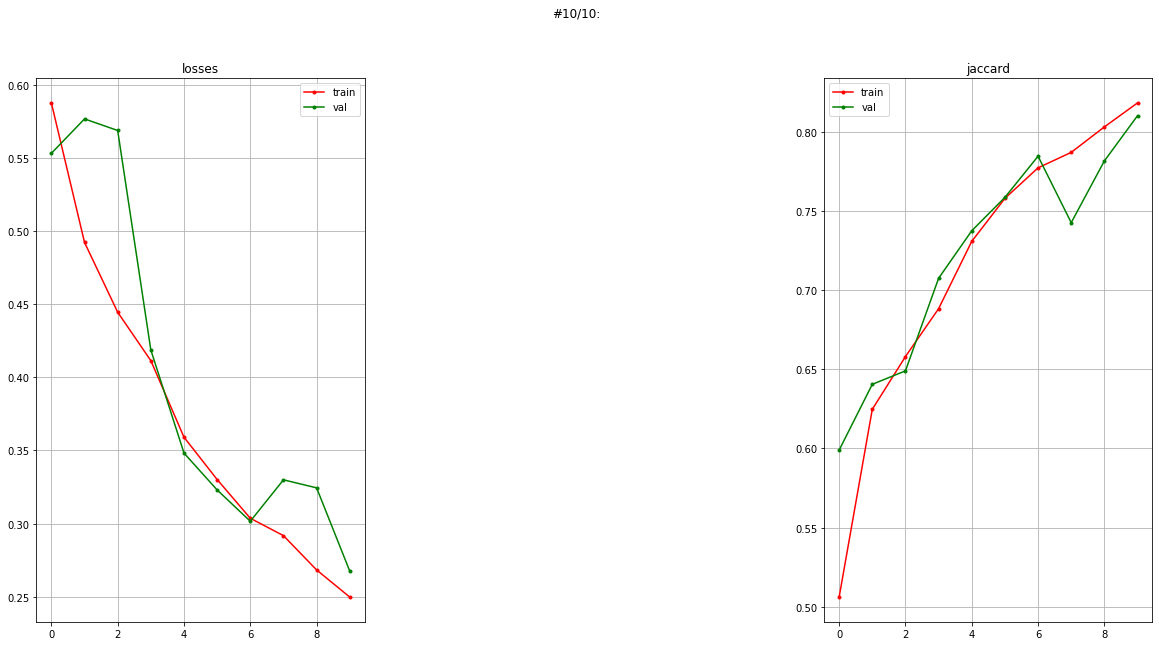

TypeError: cannot unpack non-iterable UNET object

In [29]:
#!g1.4
second_model = run_kth_model(1)

[0.5240734330443448, 0.6355943069901577, 0.6874104017435119, 0.7267002588094666, 0.7563992794169936, 0.7722174400507018, 0.7939650430235752, 0.809647471405739, 0.817249289778776, 0.8333713523177213]


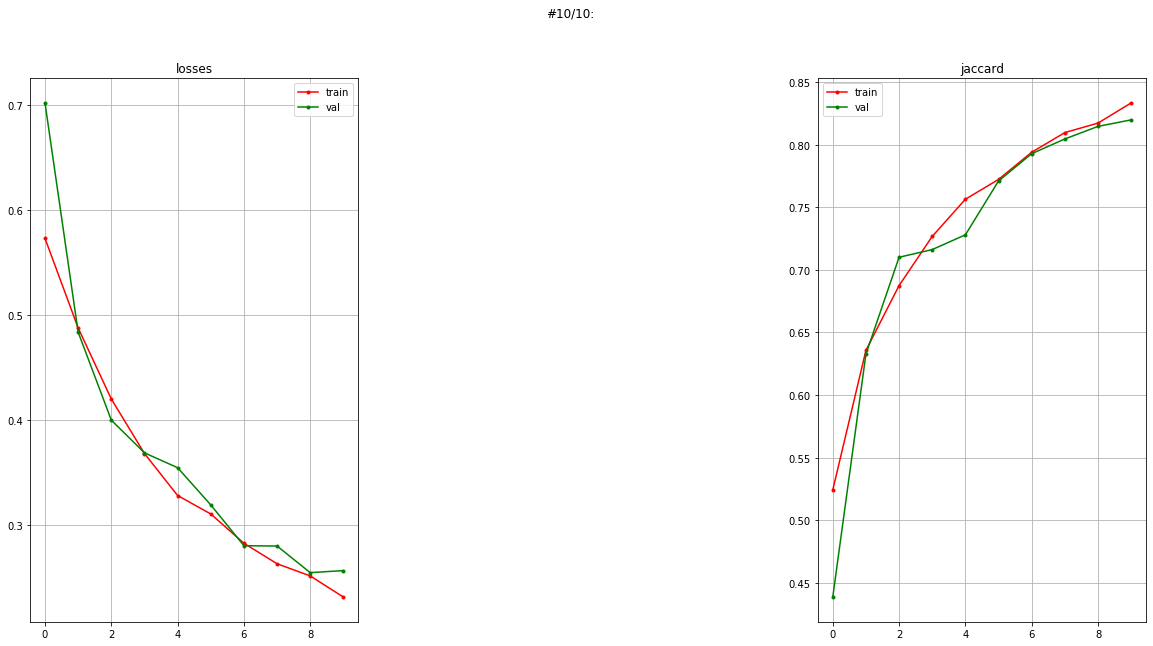

In [30]:
#!g1.4
third_model = run_kth_model(2)

[0.5017162138639495, 0.6214565704035204, 0.6800036319466525, 0.6992027288259461, 0.723248164321101, 0.7369475572608238, 0.753072788549024, 0.7738983381626218, 0.7921115603557852, 0.8066105399020883]


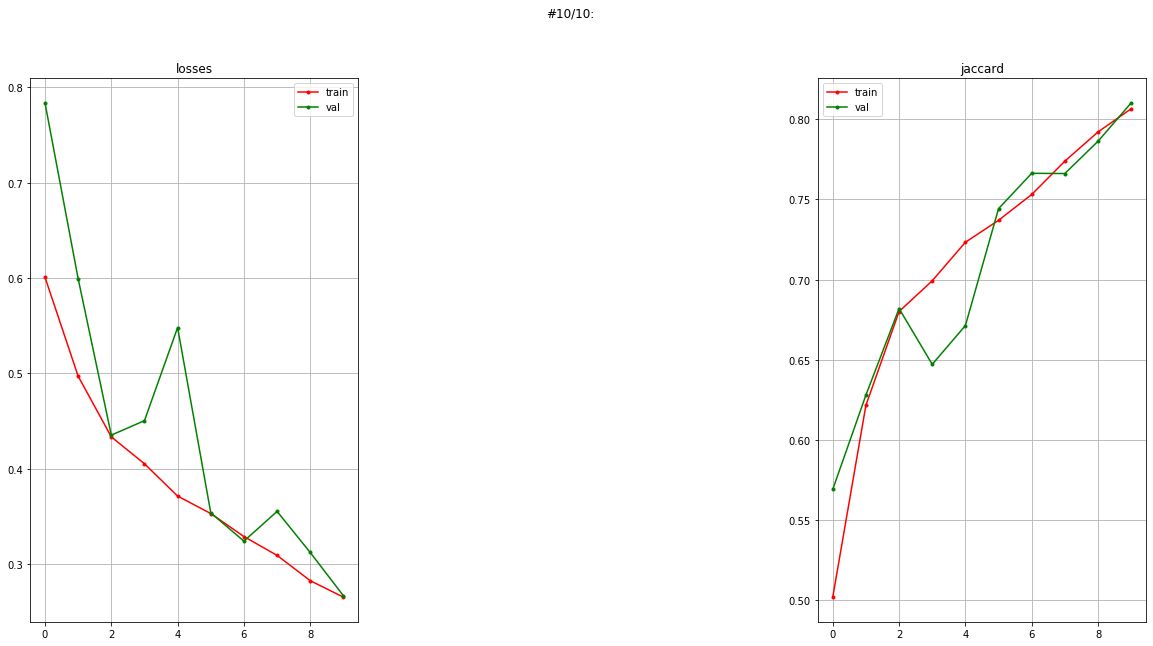

In [31]:
#!g1.4
fourth_model = run_kth_model(3)

[0.5940021810143493, 0.6698555793873099, 0.7222483463065569, 0.7532246348469757, 0.7758384735085243, 0.7925633843555007, 0.8141448137372039, 0.8270946214365404, 0.8289286674455155, 0.8426078045090963]


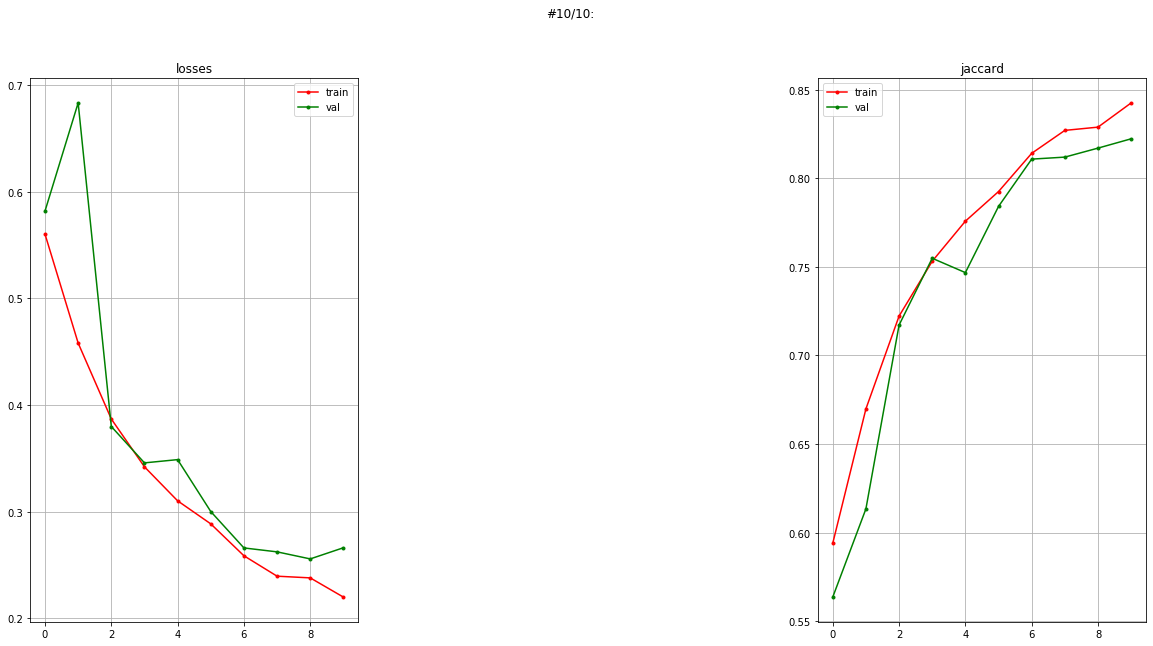

In [32]:
#!g1.4
fifth_model = run_kth_model(4)

## Видим, что модели неплохо учатся на фолдах, теперь глянем на топ 3 плохих предсказаний

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


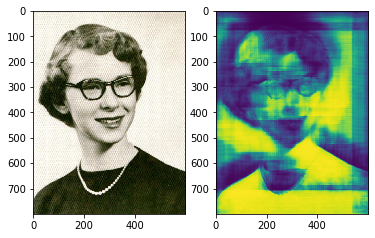

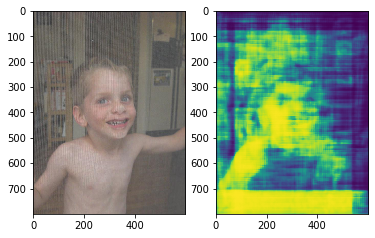

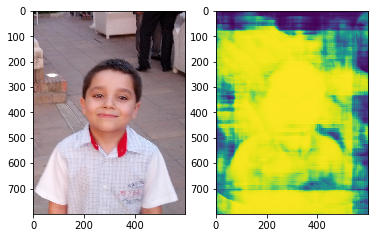

In [35]:
#!g1.1
worst_idxs = show_worst_test_cases(first_model, 3)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


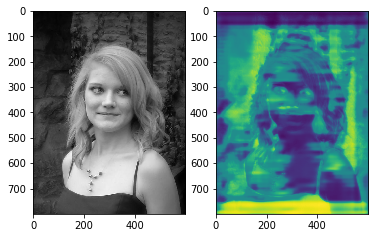

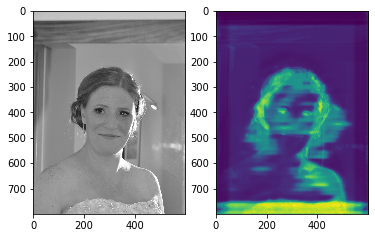

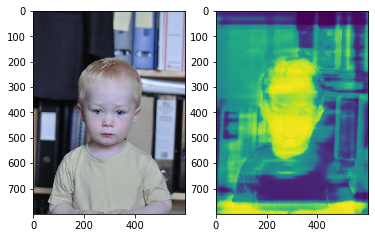

In [523]:
#!g1.1
worst_idxs = show_worst_test_cases(second_model, 3)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


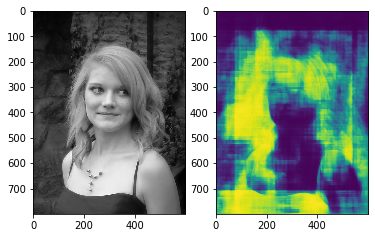

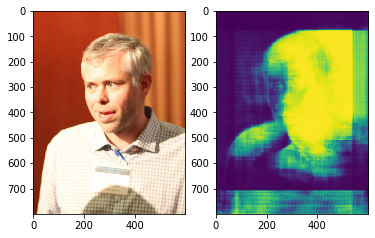

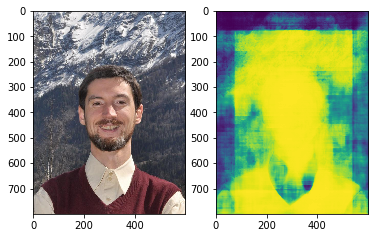

In [36]:
#!g1.1
worst_idxs = show_worst_test_cases(third_model, 3)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


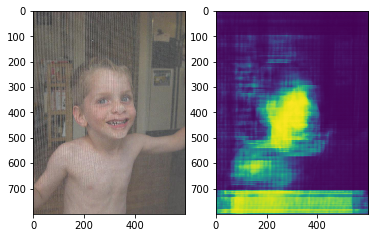

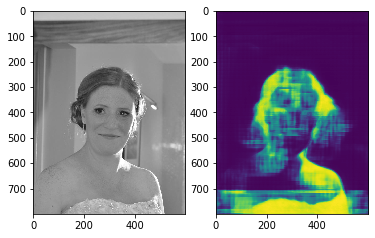

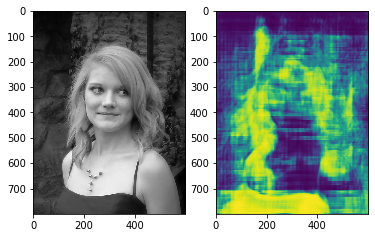

In [37]:
#!g1.1
worst_idxs = show_worst_test_cases(fourth_model, 3)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


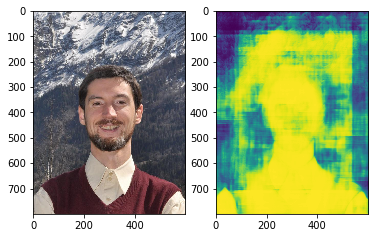

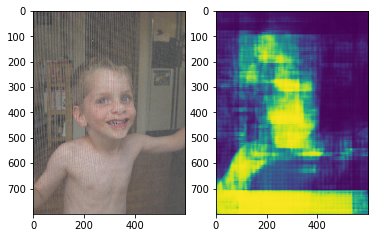

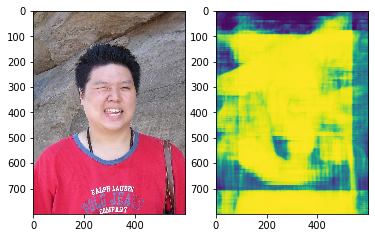

In [38]:
#!g1.1
worst_idxs = show_worst_test_cases(fifth_model, 3)

## Почти все модели имеют общие плохие предсказания, значит там какой-то плохой паттерн, который плохо улавливается

In [44]:
# #!g1.4
# class AggModel(nn.Module):
#     def __init__(self):
#         super(AggModel, self).__init__()
#         self.models = [first_model, third_model, fourth_model, fifth_model]

#     def forward(self, x):
#         f, t, f, ff = [mdl(x) for mdl in self.models]
#         return (f + t + f + ff) / 4

## Выводы
- Самые лучшие показатели у обычной UNET с аугментацией 
- Моделька с vgg энкодером показала лучшие результаты
- На кросс-валидации модельки показали неплохое качество, только сагрегировать результат не вышло(кажется вся память на гпу умерла и баги полезли)
- Результаты у модельки на полном датасете сопоставимы с модельками на фолдах
- Модельки на разных фолдах плохо справляются с некоторыми общими фото, но также и плохо различают некоторые особенные
- Test-time работает хуже обычной модельки
